In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np, tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import os
import csv
import gc
from sklearn.metrics import mean_squared_error
import math
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'



PRICED_BITCOIN_FILE_PATH = "C:/Users/wang.yuhao/Documents/ChainNet/data/original_data/pricedBitcoin2009-2018.csv"
DAILY_OCCURRENCE_FILE_PATH = "C:/Users/wang.yuhao/Documents/ChainNet/data/original_data/dailyOccmatrices/"


ROW = -1
COLUMN = -1
TEST_SPLIT = 0.01



ALL_YEAR_INPUT_ALLOWED = False
YEAR = 2017



IS_PRICE_OF_PREVIOUS_DAYS_ALLOWED:  True
AGGREGATION_OF_PREVIOUS_DAYS_ALLOWED:  False
WINDOW_SIZE:  3
PREDICTION_HORIZON:  1
PREDICTION_HORIZON:  2
PREDICTION_HORIZON:  5
PREDICTION_HORIZON:  7
PREDICTION_HORIZON:  10
PREDICTION_HORIZON:  15
PREDICTION_HORIZON:  20
PREDICTION_HORIZON:  25
PREDICTION_HORIZON:  30
rmse_array: [12.832877531423264, 18.509245767866105, 66.66476270997691, 83.84262755140071, 92.06286536108928, 168.46719412949506, 334.25515671794733, 502.67172086715937, 463.46864208011766]


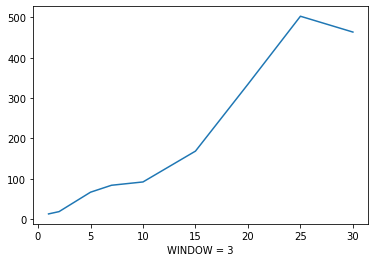

WINDOW_SIZE:  5
PREDICTION_HORIZON:  1
PREDICTION_HORIZON:  2
PREDICTION_HORIZON:  5
PREDICTION_HORIZON:  7
PREDICTION_HORIZON:  10
PREDICTION_HORIZON:  15
PREDICTION_HORIZON:  20
PREDICTION_HORIZON:  25
PREDICTION_HORIZON:  30
rmse_array: [15.283981387542099, 27.527940692854827, 77.64689401293822, 79.69990740349726, 124.98468698259285, 233.70026291610407, 345.5498888892039, 539.6175619994922, 309.51835410333]


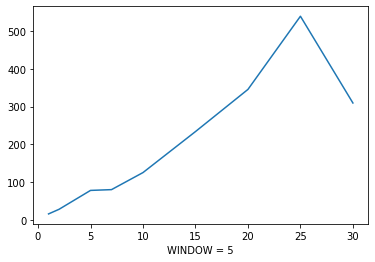

WINDOW_SIZE:  7
PREDICTION_HORIZON:  1
PREDICTION_HORIZON:  2
PREDICTION_HORIZON:  5
PREDICTION_HORIZON:  7
PREDICTION_HORIZON:  10
PREDICTION_HORIZON:  15
PREDICTION_HORIZON:  20
PREDICTION_HORIZON:  25
PREDICTION_HORIZON:  30
rmse_array: [25.269781370696137, 53.9848269882209, 66.23106860426788, 97.88427009297061, 164.65228849442065, 306.0274028956578, 419.15388232641794, 455.54630773279655, 472.29886564383855]


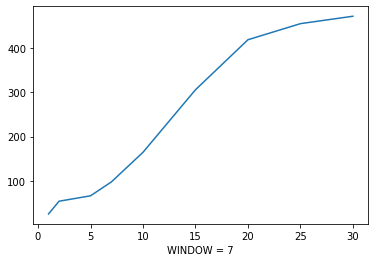

In [42]:
# Baseline

from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt

def exclude_days(train, test):

    row, column = train.shape
    train_days = np.asarray(train[:, -1]).reshape(-1, 1)
    x_train = train[:, 0:column - 1]
    test_days = np.asarray(test[:, -1]).reshape(-1, 1)
    x_test = test[:, 0:column - 1]

    return x_train, x_test, train_days, test_days

def merge_data(occurrence_data, daily_occurrence_normalized_matrix, aggregation_of_previous_days_allowed):
    if(aggregation_of_previous_days_allowed):
        if(occurrence_data.size==0):
            occurrence_data = daily_occurrence_normalized_matrix
        else:
            occurrence_data = np.add(occurrence_data, daily_occurrence_normalized_matrix)
    else:
        if(occurrence_data.size == 0):
            occurrence_data = daily_occurrence_normalized_matrix
        else:
            occurrence_data = np.concatenate((occurrence_data, daily_occurrence_normalized_matrix), axis=1)
   #print("merge_data shape: {} occurrence_data: {} ".format(occurrence_data.shape, occurrence_data))
    return occurrence_data
    
    
def get_normalized_matrix_from_file(day, year, totaltx):
    daily_occurrence_matrix_path_name = DAILY_OCCURRENCE_FILE_PATH + "occ" + str(year) + '{:03}'.format(day) + '.csv'
    daily_occurence_matrix = pd.read_csv(daily_occurrence_matrix_path_name, sep=",", header=None).values
   #print("daily_occurence_matrix.size: ", daily_occurence_matrix.size, daily_occurence_matrix.shape)
   #print("np.asarray(daily_occurence_matrix): ",np.asarray(daily_occurence_matrix))
   #print("np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size): ",np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size), np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size).shape, np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size).size)
   #print("totaltx: ",totaltx)
   #print("np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size)/totaltx: ",np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size)/totaltx)
    return np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size)/totaltx

def get_daily_occurrence_matrices(priced_bitcoin, current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
   #print("priced_bitcoin: ", priced_bitcoin, priced_bitcoin.shape)
   #print("current_row: ", current_row, current_row.shape)
    previous_price_data = np.array([], dtype=np.float32)
    occurrence_data = np.array([], dtype=np.float32)
    for index, row in priced_bitcoin.iterrows():
        if not ((row.values == current_row.values).all()):
            previous_price_data = np.append(previous_price_data, row['price'])
            previous_price_data = np.append(previous_price_data, row['totaltx'])
           #print("previous_price_data: ", previous_price_data,row['day'], row['year'], row['totaltx'])

    
   #print("occurrence_data: ", occurrence_data)
    if(is_price_of_previous_days_allowed):
       #print("previous_price_data: ", np.asarray(previous_price_data).reshape(1, -1), np.asarray(previous_price_data).reshape(1, -1).shape)
        occurrence_data = np.asarray(previous_price_data).reshape(1, -1)
    occurrence_input = np.concatenate((occurrence_data, np.asarray(current_row['price']).reshape(1,1)), axis=1)
   #print("current_row: ", current_row, current_row.shape)
   #print(" price occurrence_input: ", np.asarray(current_row['price']).reshape(1,1), (np.asarray(current_row['price']).reshape(1,1)).shape)
   #print("concatenate with price occurrence_input: ", occurrence_input, occurrence_input.shape)
    occurrence_input = np.concatenate((occurrence_input, np.asarray(current_row['day']).reshape(1,1)), axis=1)
   #print(" price occurrence_input: ", np.asarray(current_row['day']).reshape(1,1), (np.asarray(current_row['day']).reshape(1,1)).shape)

   #print("concatenate with day occurrence_input: ", occurrence_input, occurrence_input.shape)
    return occurrence_input


def print_results(predicted, test_target, original_log_return, predicted_log_return, cost, test_days, rmse):
    myFile = open('C:/Users/wang.yuhao/Documents/ChainNet/data/processed_data/rmse/' + str(YEAR) + ".csv", 'a')
    if(window_size == 1):
        myFile.write('IS_PRICE_OF_PREVIOUS_DAYS_ALLOWED:' + str(is_price_of_previous_days_allowed) + '\n')
        myFile.write('AGGREGATION_OF_PREVIOUS_DAYS_ALLOWED:' + str(aggregation_of_previous_days_allowed) + '\n')

        myFile.write('PREDICTION_HORIZON:' + str(prediction_horizon) + '\n')
    myFile.write('WINDOW_SIZE:' + str(window_size) + '\n')

    for p, t, o_l, p_l, t_d in zip(predicted, test_target, original_log_return, predicted_log_return, test_days):
        myFile.write(str(p) + "\t" + str(t) + "\t" + str(o_l) + "\t" + str(p_l) + "\t" + str(t_d) + '\n')
    myFile.write('TEST_COST:' + str(cost) + '\n')
    myFile.write('RMSE:' + str(rmse) + '\n')
    myFile.close()


def run_print_model(train_input, train_target, test_input, test_target, train_days, test_days):
    rf_regression = RandomForestRegressor(max_depth=2, random_state=0)
    rf_regression.fit(train_input, train_target.ravel() )
    predicted = rf_regression.predict(test_input)
    original_log_return = np.log(np.asarray(test_target).reshape(-1,)/test_input[:,-1])
    predicted_log_return = np.log(np.asarray(predicted).reshape(-1,)/test_input[:,-1])
    cost = sum(np.absolute(original_log_return-predicted_log_return))/original_log_return.size
    rmse = np.sqrt(metrics.mean_squared_error(test_target, predicted))
    print_results(predicted, test_target, original_log_return, predicted_log_return, cost, test_days, rmse)
    return rmse

def preprocess_data(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
    priced_bitcoin = pd.read_csv(PRICED_BITCOIN_FILE_PATH, sep=",")
    if(ALL_YEAR_INPUT_ALLOWED):
        pass
    else:
        priced_bitcoin = priced_bitcoin[priced_bitcoin['year']==YEAR].reset_index(drop=True)
    
    # get normalized occurence matrix in a flat format and merge with totaltx
    daily_occurrence_input = np.array([],dtype=np.float32)
    temp = np.array([], dtype=np.float32)
    for current_index, current_row in priced_bitcoin.iterrows():
        if(current_index<(window_size+prediction_horizon-1)):
            pass
        else:
            start_index = current_index - (window_size + prediction_horizon) + 1
            end_index = current_index - prediction_horizon
            temp = get_daily_occurrence_matrices(priced_bitcoin[start_index:end_index+1], current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)    
            #print("1st temp: ", temp, temp.shape)
        if(daily_occurrence_input.size == 0):
            daily_occurrence_input = temp
        else:
            #print("daily_occurrence_input: ", daily_occurrence_input, daily_occurrence_input.shape)
            #print("temp: ", temp, temp.shape)
            daily_occurrence_input = np.concatenate((daily_occurrence_input, temp), axis=0)
            #print("return daily_occurrence_input:", daily_occurrence_input, daily_occurrence_input.shape)
            
        #if current_index == 108:
            #print("daily_occurrence_input: ", daily_occurrence_input, daily_occurrence_input.shape)
    return daily_occurrence_input
        
        
    
def initialize_setting(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
    data = preprocess_data(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)
    #train, test = train_test_split(data, test_size=TEST_SPLIT)
    #data = pd.DataFrame(data)
    train = data[0:100, :]
    test = data[101, :].reshape(1, -1)
    #print(" train, test shape",train.shape, test.shape)
    #print(" train, test",train, test)
    
    x_train, x_test, train_days, test_days = exclude_days(train, test)
    #print("x_train:", x_train)
    row, column = x_train.shape
    train_target = np.asarray(x_train[:, -1]).reshape(-1)
    train_input = x_train[:, 0:column - 1]
    #x_test = x_test.reshape(-1,1)
    test_target = x_test[: , -1]
    test_input = x_test[ : , 0:column - 1]
    return train_input, train_target, test_input, test_target, train_days, test_days

parameter_dict = {#0: dict({'is_price_of_previous_days_allowed':True, 'aggregation_of_previous_days_allowed':True})}
                  1: dict({'is_price_of_previous_days_allowed':True, 'aggregation_of_previous_days_allowed':False})}

for step in parameter_dict:
    gc.collect()
    evalParameter = parameter_dict.get(step)
    is_price_of_previous_days_allowed = evalParameter.get('is_price_of_previous_days_allowed')
    aggregation_of_previous_days_allowed = evalParameter.get('aggregation_of_previous_days_allowed')
    print("IS_PRICE_OF_PREVIOUS_DAYS_ALLOWED: ", is_price_of_previous_days_allowed)
    print("AGGREGATION_OF_PREVIOUS_DAYS_ALLOWED: ", aggregation_of_previous_days_allowed)
    window_size_array = [3, 5, 7]
    horizon_size_array = [1, 2, 5, 7, 10, 15, 20, 25, 30]
    for window_size in window_size_array:
        print('WINDOW_SIZE: ', window_size)
        rmse_array = []
        for prediction_horizon in horizon_size_array:
            print("PREDICTION_HORIZON: ", prediction_horizon)
            train_input, train_target, test_input, test_target, train_days, test_days = initialize_setting(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)
            #print("train_input, train_target: ",train_input, train_target, train_input.shape, train_target.shape)
            #print("test_input, test_target",test_input, test_target, test_input.shape, test_target.shape)
            #print("train_days, test_days: ",train_days, test_days)
            rmse = run_print_model(train_input, train_target, test_input, test_target, train_days, test_days)
            rmse_array.append(rmse)
            
        print("rmse_array:", rmse_array)    
        plt.plot(horizon_size_array, rmse_array)
        plt.xlabel('WINDOW = {}'.format(window_size))
        plt.show()
        
        

IS_PRICE_OF_PREVIOUS_DAYS_ALLOWED:  True
AGGREGATION_OF_PREVIOUS_DAYS_ALLOWED:  False
WINDOW_SIZE:  3
PREDICTION_HORIZON:  1
PREDICTION_HORIZON:  2
PREDICTION_HORIZON:  5
PREDICTION_HORIZON:  7
PREDICTION_HORIZON:  10
PREDICTION_HORIZON:  15
PREDICTION_HORIZON:  20
PREDICTION_HORIZON:  25
PREDICTION_HORIZON:  30
rmse_array: [13.060495582872136, 17.58548407450644, 45.55190439335274, 86.86376369413301, 103.96516153140351, 162.97720124835723, 347.2111840960322, 365.0863552605301, 607.1192048408702]


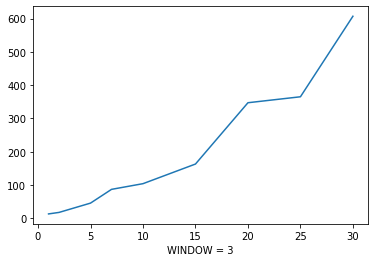

WINDOW_SIZE:  5
PREDICTION_HORIZON:  1
PREDICTION_HORIZON:  2
PREDICTION_HORIZON:  5
PREDICTION_HORIZON:  7
PREDICTION_HORIZON:  10
PREDICTION_HORIZON:  15
PREDICTION_HORIZON:  20
PREDICTION_HORIZON:  25
PREDICTION_HORIZON:  30
rmse_array: [17.323702664027678, 24.11226149838012, 77.74046160817716, 82.13503767073075, 128.88469383817983, 238.3165165706173, 348.6321516330406, 514.4418509994518, 232.49094684228567]


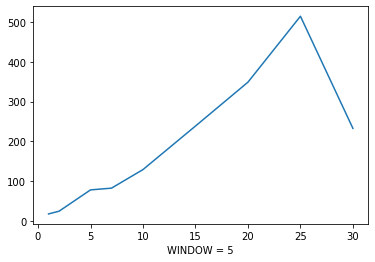

WINDOW_SIZE:  7
PREDICTION_HORIZON:  1
PREDICTION_HORIZON:  2
PREDICTION_HORIZON:  5
PREDICTION_HORIZON:  7
PREDICTION_HORIZON:  10
PREDICTION_HORIZON:  15
PREDICTION_HORIZON:  20
PREDICTION_HORIZON:  25
PREDICTION_HORIZON:  30
rmse_array: [25.376655430498204, 55.32898247802723, 85.67709672002661, 79.9818570592688, 172.15773384869203, 306.8881306659846, 371.8673186155572, 571.8421154989296, 255.69975413625025]


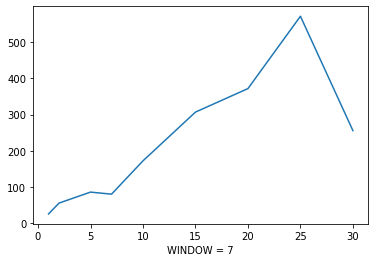

In [43]:
# Betti
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt

def exclude_days(train, test):

    row, column = train.shape
    train_days = np.asarray(train[:, -1]).reshape(-1, 1)
    x_train = train[:, 0:column - 1]
    test_days = np.asarray(test[:, -1]).reshape(-1, 1)
    x_test = test[:, 0:column - 1]

    return x_train, x_test, train_days, test_days

def merge_data(occurrence_data, daily_occurrence_normalized_matrix, aggregation_of_previous_days_allowed):
    if(aggregation_of_previous_days_allowed):
        if(occurrence_data.size==0):
            occurrence_data = daily_occurrence_normalized_matrix
        else:
            occurrence_data = np.add(occurrence_data, daily_occurrence_normalized_matrix)
    else:
        if(occurrence_data.size == 0):
            occurrence_data = daily_occurrence_normalized_matrix
        else:
            occurrence_data = np.concatenate((occurrence_data, daily_occurrence_normalized_matrix), axis=1)
   #print("merge_data shape: {} occurrence_data: {} ".format(occurrence_data.shape, occurrence_data))
    return occurrence_data
    
    
def get_normalized_matrix_from_file(day, year, totaltx):
    daily_occurrence_matrix_path_name = DAILY_OCCURRENCE_FILE_PATH + "occ" + str(year) + '{:03}'.format(day) + '.csv'
    daily_occurence_matrix = pd.read_csv(daily_occurrence_matrix_path_name, sep=",", header=None).values
   #print("daily_occurence_matrix.size: ", daily_occurence_matrix.size, daily_occurence_matrix.shape)
   #print("np.asarray(daily_occurence_matrix): ",np.asarray(daily_occurence_matrix))
   #print("np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size): ",np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size), np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size).shape, np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size).size)
   #print("totaltx: ",totaltx)
   #print("np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size)/totaltx: ",np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size)/totaltx)
    return np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size)/totaltx

def get_daily_occurrence_matrices(priced_bitcoin, current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
   #print("priced_bitcoin: ", priced_bitcoin, priced_bitcoin.shape)
   #print("current_row: ", current_row, current_row.shape)
    previous_price_data = np.array([], dtype=np.float32)
    occurrence_data = np.array([], dtype=np.float32)
    for index, row in priced_bitcoin.iterrows():
        if not ((row.values == current_row.values).all()):
            previous_price_data = np.append(previous_price_data, row['price'])
            previous_price_data = np.append(previous_price_data, row['totaltx'])
           #print("previous_price_data: ", previous_price_data,row['day'], row['year'], row['totaltx'])

    
   #print("occurrence_data: ", occurrence_data)
    if(is_price_of_previous_days_allowed):
       #print("previous_price_data: ", np.asarray(previous_price_data).reshape(1, -1), np.asarray(previous_price_data).reshape(1, -1).shape)
        occurrence_data = np.asarray(previous_price_data).reshape(1, -1)
    betti0_50 = read_betti(betti0_input_path, current_row['day'])
    occurrence_input = np.concatenate((occurrence_data, np.asarray(betti0_50).reshape(1,-1)), axis=1)

    betti1_50 = read_betti(betti1_input_path, current_row['day'])
    occurrence_input = np.concatenate((occurrence_input, np.asarray(betti1_50).reshape(1,-1)), axis=1)
    occurrence_input = np.concatenate((occurrence_input, np.asarray(current_row['price']).reshape(1,1)), axis=1)
   #print("current_row['day']: ", current_row['day'], current_row['day'].shape)
   #print(" price occurrence_input: ", np.asarray(current_row['price']).reshape(1,1), (np.asarray(current_row['price']).reshape(1,1)).shape)
   #print("concatenate with price occurrence_input: ", occurrence_input, occurrence_input.shape)
    occurrence_input = np.concatenate((occurrence_input, np.asarray(current_row['day']).reshape(1,1)), axis=1)
   #print(" price occurrence_input: ", np.asarray(current_row['day']).reshape(1,1), (np.asarray(current_row['day']).reshape(1,1)).shape)

    #print("concatenate with day occurrence_input: ", occurrence_input, occurrence_input.shape)

    return occurrence_input


def print_results(predicted, test_target, original_log_return, predicted_log_return, cost, test_days, rmse):
    myFile = open('C:/Users/wang.yuhao/Documents/ChainNet/data/processed_data/rmse/' + str(YEAR) + ".csv", 'a')
    if(window_size == 1):
        myFile.write('IS_PRICE_OF_PREVIOUS_DAYS_ALLOWED:' + str(is_price_of_previous_days_allowed) + '\n')
        myFile.write('AGGREGATION_OF_PREVIOUS_DAYS_ALLOWED:' + str(aggregation_of_previous_days_allowed) + '\n')

        myFile.write('PREDICTION_HORIZON:' + str(prediction_horizon) + '\n')
    myFile.write('WINDOW_SIZE:' + str(window_size) + '\n')

    for p, t, o_l, p_l, t_d in zip(predicted, test_target, original_log_return, predicted_log_return, test_days):
        myFile.write(str(p) + "\t" + str(t) + "\t" + str(o_l) + "\t" + str(p_l) + "\t" + str(t_d) + '\n')
    myFile.write('TEST_COST:' + str(cost) + '\n')
    myFile.write('RMSE:' + str(rmse) + '\n')
    myFile.close()


def run_print_model(train_input, train_target, test_input, test_target, train_days, test_days):
    rf_regression = RandomForestRegressor(max_depth=2, random_state=0)
    rf_regression.fit(train_input, train_target.ravel() )
    predicted = rf_regression.predict(test_input)
    original_log_return = np.log(np.asarray(test_target).reshape(-1,)/test_input[:,-1])
    predicted_log_return = np.log(np.asarray(predicted).reshape(-1,)/test_input[:,-1])
    cost = sum(np.absolute(original_log_return-predicted_log_return))/original_log_return.size
    rmse = np.sqrt(metrics.mean_squared_error(test_target, predicted))
    print_results(predicted, test_target, original_log_return, predicted_log_return, cost, test_days, rmse)
    return rmse

def preprocess_data(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
    priced_bitcoin = pd.read_csv(PRICED_BITCOIN_FILE_PATH, sep=",")
    if(ALL_YEAR_INPUT_ALLOWED):
        pass
    else:
        priced_bitcoin = priced_bitcoin[priced_bitcoin['year']==YEAR].reset_index(drop=True)
    
    # get normalized occurence matrix in a flat format and merge with totaltx
    daily_occurrence_input = np.array([],dtype=np.float32)
    temp = np.array([], dtype=np.float32)
    for current_index, current_row in priced_bitcoin.iterrows():
        if(current_index<(window_size+prediction_horizon-1)):
            pass
        else:
            start_index = current_index - (window_size + prediction_horizon) + 1
            end_index = current_index - prediction_horizon
            temp = get_daily_occurrence_matrices(priced_bitcoin[start_index:end_index+1], current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)    
            #print("1st temp: ", temp, temp.shape)
        if(daily_occurrence_input.size == 0):
            daily_occurrence_input = temp
        else:
            #print("daily_occurrence_input: ", daily_occurrence_input, daily_occurrence_input.shape)
            #print("temp: ", temp, temp.shape)
            daily_occurrence_input = np.concatenate((daily_occurrence_input, temp), axis=0)
            #print("return daily_occurrence_input:", daily_occurrence_input, daily_occurrence_input.shape)
            
        #if current_index == 108:
            #print("daily_occurrence_input: ", daily_occurrence_input, daily_occurrence_input.shape)
    return daily_occurrence_input
        
betti0_input_path = "C:/Users/wang.yuhao/Documents/ChainNet/data/original_data/betti_0(100).csv"
betti1_input_path = "C:/Users/wang.yuhao/Documents/ChainNet/data/original_data/betti_1(100).csv"

def read_betti(file_path, day):
    day = day - 1
    betti = pd.read_csv(file_path, index_col=0)
    try:
        betti_50 = betti.iloc[day, 0:50]
    except:
        print("day:",  day)
            
    return betti_50
    
    
def initialize_setting(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
    data = preprocess_data(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)
    #train, test = train_test_split(data, test_size=TEST_SPLIT)
    #data = pd.DataFrame(data)
    train = data[0:100, :]
    test = data[101, :].reshape(1, -1)
    #print(" train, test shape",train.shape, test.shape)
    #print(" train, test",train, test)
    
    x_train, x_test, train_days, test_days = exclude_days(train, test)
    #print("x_train:", x_train)
    row, column = x_train.shape
    train_target = np.asarray(x_train[:, -1]).reshape(-1)
    train_input = x_train[:, 0:column - 1]
    #x_test = x_test.reshape(-1,1)
    test_target = x_test[: , -1]
    test_input = x_test[ : , 0:column - 1]
    return train_input, train_target, test_input, test_target, train_days, test_days

parameter_dict = {#0: dict({'is_price_of_previous_days_allowed':True, 'aggregation_of_previous_days_allowed':True})}
                  1: dict({'is_price_of_previous_days_allowed':True, 'aggregation_of_previous_days_allowed':False})}

for step in parameter_dict:
    gc.collect()
    evalParameter = parameter_dict.get(step)
    is_price_of_previous_days_allowed = evalParameter.get('is_price_of_previous_days_allowed')
    aggregation_of_previous_days_allowed = evalParameter.get('aggregation_of_previous_days_allowed')
    print("IS_PRICE_OF_PREVIOUS_DAYS_ALLOWED: ", is_price_of_previous_days_allowed)
    print("AGGREGATION_OF_PREVIOUS_DAYS_ALLOWED: ", aggregation_of_previous_days_allowed)
    window_size_array = [3, 5, 7]
    horizon_size_array = [1, 2, 5, 7, 10, 15, 20, 25, 30]
    for window_size in window_size_array:
        print('WINDOW_SIZE: ', window_size)
        rmse_array = []
        for prediction_horizon in horizon_size_array:
            print("PREDICTION_HORIZON: ", prediction_horizon)
            train_input, train_target, test_input, test_target, train_days, test_days = initialize_setting(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)
            #print("train_input, train_target: ",train_input, train_target, train_input.shape, train_target.shape)
            #print("test_input, test_target",test_input, test_target, test_input.shape, test_target.shape)
            #print("train_days, test_days: ",train_days, test_days)
            rmse = run_print_model(train_input, train_target, test_input, test_target, train_days, test_days)
            rmse_array.append(rmse)
            
        print("rmse_array:", rmse_array)    
        plt.plot(horizon_size_array, rmse_array)
        plt.xlabel('WINDOW = {}'.format(window_size))
        plt.show()
        
        

IS_PRICE_OF_PREVIOUS_DAYS_ALLOWED:  True
AGGREGATION_OF_PREVIOUS_DAYS_ALLOWED:  False
WINDOW_SIZE:  3
PREDICTION_HORIZON:  1
PREDICTION_HORIZON:  2
PREDICTION_HORIZON:  5
PREDICTION_HORIZON:  7
PREDICTION_HORIZON:  10
PREDICTION_HORIZON:  15
PREDICTION_HORIZON:  20
PREDICTION_HORIZON:  25
PREDICTION_HORIZON:  30
rmse_array: [17.578994985125746, 8.508985831467044, 46.47942367148835, 88.41591803112101, 64.55678874602995, 141.67290557191336, 307.0876938257302, 430.0776092536257, 377.31445666526224]


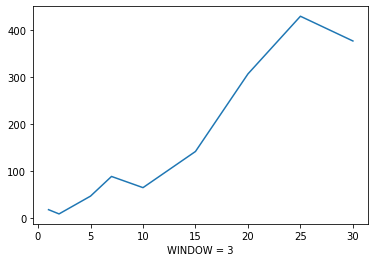

WINDOW_SIZE:  5
PREDICTION_HORIZON:  1
PREDICTION_HORIZON:  2
PREDICTION_HORIZON:  5
PREDICTION_HORIZON:  7
PREDICTION_HORIZON:  10
PREDICTION_HORIZON:  15
PREDICTION_HORIZON:  20
PREDICTION_HORIZON:  25
PREDICTION_HORIZON:  30
rmse_array: [8.45939193278241, 30.04451089325721, 87.89571653105736, 104.69484116182116, 98.77221842391214, 210.82483578559481, 300.2608707274262, 473.131141659135, 345.28596475861536]


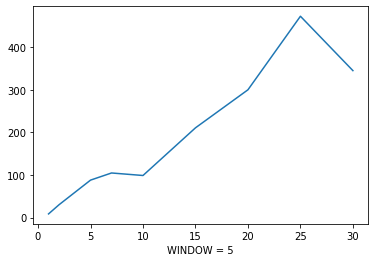

WINDOW_SIZE:  7
PREDICTION_HORIZON:  1


In [ ]:
# Fl 
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

DAILY_FILTERED_OCCURRENCE_FILE_PATH = "C:/Users/wang.yuhao/Documents/ChainNet/data/original_data/filteredDailyOccMatrices/"

def exclude_days(train, test):

    row, column = train.shape
    train_days = np.asarray(train[:, -1]).reshape(-1, 1)
    x_train = train[:, 0:column - 1]
    test_days = np.asarray(test[:, -1]).reshape(-1, 1)
    x_test = test[:, 0:column - 1]

    return x_train, x_test, train_days, test_days

def merge_data(occurrence_data, daily_occurrence_normalized_matrix, aggregation_of_previous_days_allowed):
    if(aggregation_of_previous_days_allowed):
        if(occurrence_data.size==0):
            occurrence_data = daily_occurrence_normalized_matrix
        else:
            occurrence_data = np.add(occurrence_data, daily_occurrence_normalized_matrix)
    else:
        if(occurrence_data.size == 0):
            occurrence_data = daily_occurrence_normalized_matrix
        else:
            occurrence_data = np.concatenate((occurrence_data, daily_occurrence_normalized_matrix), axis=1)
   #print("merge_data shape: {} occurrence_data: {} ".format(occurrence_data.shape, occurrence_data))
    return occurrence_data
    
    
def get_normalized_matrix_from_file(day, year, totaltx):
    daily_occurence_matrix = np.asarray([],dtype=np.float32)
    for filter_number in range(0, 50, 10):
        daily_occurrence_matrix_path_name = DAILY_FILTERED_OCCURRENCE_FILE_PATH + "occ" + str(year) + '{:03}'.format(day) + "_" + str(filter_number) +'.csv'
        daily_occurence_matrix_read = pd.read_csv(daily_occurrence_matrix_path_name, sep=",", header=None).values
        if(daily_occurence_matrix.size == 0):
            daily_occurence_matrix = daily_occurence_matrix_read
        else:
            daily_occurence_matrix = np.concatenate((daily_occurence_matrix, daily_occurence_matrix_read), axis = 1)
   #print("daily_occurence_matrix.size: ", daily_occurence_matrix.size, daily_occurence_matrix.shape)
   #print("np.asarray(daily_occurence_matrix): ",np.asarray(daily_occurence_matrix))
   #print("np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size): ",np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size), np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size).shape, np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size).size)
   #print("totaltx: ",totaltx)
   #print("np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size)/totaltx: ",np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size)/totaltx)
    return np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size)/totaltx

def get_daily_occurrence_matrices(priced_bitcoin, current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
   #print("priced_bitcoin: ", priced_bitcoin, priced_bitcoin.shape)
   #print("current_row: ", current_row, current_row.shape)
    previous_price_data = np.array([], dtype=np.float32)
    occurrence_data = np.array([], dtype=np.float32)
    for index, row in priced_bitcoin.iterrows():
        if not ((row.values == current_row.values).all()):
            previous_price_data = np.append(previous_price_data, row['price'])
            previous_price_data = np.append(previous_price_data, row['totaltx'])
            daily_occurrence_normalized_matrix = get_normalized_matrix_from_file(row['day'], row['year'], row['totaltx'])
            occurrence_data = merge_data(occurrence_data, daily_occurrence_normalized_matrix, aggregation_of_previous_days_allowed)
            #print("daily_occurrence_normalized_matrix: ", daily_occurrence_normalized_matrix,daily_occurrence_normalized_matrix.shape)

    
   #print("occurrence_data: ", occurrence_data)
    if(is_price_of_previous_days_allowed):
       #print("previous_price_data: ", np.asarray(previous_price_data).reshape(1, -1), np.asarray(previous_price_data).reshape(1, -1).shape)
        occurrence_data = np.concatenate((occurrence_data, np.asarray(previous_price_data).reshape(1,-1)), axis=1)

    occurrence_input = np.concatenate((occurrence_data, np.asarray(current_row['price']).reshape(1,1)), axis=1)
   #print("current_row['day']: ", current_row['day'], current_row['day'].shape)
   #print(" price occurrence_input: ", np.asarray(current_row['price']).reshape(1,1), (np.asarray(current_row['price']).reshape(1,1)).shape)
   #print("concatenate with price occurrence_input: ", occurrence_input, occurrence_input.shape)
    occurrence_input = np.concatenate((occurrence_input, np.asarray(current_row['day']).reshape(1,1)), axis=1)
   #print(" price occurrence_input: ", np.asarray(current_row['day']).reshape(1,1), (np.asarray(current_row['day']).reshape(1,1)).shape)

    #print("concatenate with day occurrence_input: ", occurrence_input, occurrence_input.shape)
    
    return occurrence_input


def print_results(predicted, test_target, original_log_return, predicted_log_return, cost, test_days, rmse):
    myFile = open('C:/Users/wang.yuhao/Documents/ChainNet/data/processed_data/rmse/' + str(YEAR) + ".csv", 'a')
    if(window_size == 1):
        myFile.write('IS_PRICE_OF_PREVIOUS_DAYS_ALLOWED:' + str(is_price_of_previous_days_allowed) + '\n')
        myFile.write('AGGREGATION_OF_PREVIOUS_DAYS_ALLOWED:' + str(aggregation_of_previous_days_allowed) + '\n')

        myFile.write('PREDICTION_HORIZON:' + str(prediction_horizon) + '\n')
    myFile.write('WINDOW_SIZE:' + str(window_size) + '\n')

    for p, t, o_l, p_l, t_d in zip(predicted, test_target, original_log_return, predicted_log_return, test_days):
        myFile.write(str(p) + "\t" + str(t) + "\t" + str(o_l) + "\t" + str(p_l) + "\t" + str(t_d) + '\n')
    myFile.write('TEST_COST:' + str(cost) + '\n')
    myFile.write('RMSE:' + str(rmse) + '\n')
    myFile.close()


def run_print_model(train_input, train_target, test_input, test_target, train_days, test_days):
    rf_regression = RandomForestRegressor(max_depth=2, random_state=0)
    rf_regression.fit(train_input, train_target.ravel() )
    predicted = rf_regression.predict(test_input)
    original_log_return = np.log(np.asarray(test_target).reshape(-1,)/test_input[:,-1])
    predicted_log_return = np.log(np.asarray(predicted).reshape(-1,)/test_input[:,-1])
    cost = sum(np.absolute(original_log_return-predicted_log_return))/original_log_return.size
    rmse = np.sqrt(metrics.mean_squared_error(test_target, predicted))
    print_results(predicted, test_target, original_log_return, predicted_log_return, cost, test_days, rmse)
    return rmse

def preprocess_data(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
    priced_bitcoin = pd.read_csv(PRICED_BITCOIN_FILE_PATH, sep=",")
    if(ALL_YEAR_INPUT_ALLOWED):
        pass
    else:
        priced_bitcoin = priced_bitcoin[priced_bitcoin['year']==YEAR].reset_index(drop=True)
    
    # get normalized occurence matrix in a flat format and merge with totaltx
    daily_occurrence_input = np.array([],dtype=np.float32)
    temp = np.array([], dtype=np.float32)
    for current_index, current_row in priced_bitcoin.iterrows():
        if(current_index<(window_size+prediction_horizon-1)):
            pass
        else:
            start_index = current_index - (window_size + prediction_horizon) + 1
            end_index = current_index - prediction_horizon
            temp = get_daily_occurrence_matrices(priced_bitcoin[start_index:end_index+1], current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)    
            #print("1st temp: ", temp, temp.shape)
        if(daily_occurrence_input.size == 0):
            daily_occurrence_input = temp
        else:
            #print("daily_occurrence_input: ", daily_occurrence_input, daily_occurrence_input.shape)
            #print("temp: ", temp, temp.shape)
            daily_occurrence_input = np.concatenate((daily_occurrence_input, temp), axis=0)
            #print("return daily_occurrence_input:", daily_occurrence_input, daily_occurrence_input.shape)
            
        #if current_index == 108:
            #print("daily_occurrence_input: ", daily_occurrence_input, daily_occurrence_input.shape)
    return daily_occurrence_input
        
betti0_input_path = "C:/Users/wang.yuhao/Documents/ChainNet/data/original_data/betti_0(100).csv"
betti1_input_path = "C:/Users/wang.yuhao/Documents/ChainNet/data/original_data/betti_1(100).csv"

def read_betti(file_path, day):
    day = day - 1
    betti = pd.read_csv(file_path, index_col=0)
    try:
        betti_50 = betti.iloc[day, 0:50]
    except:
        print("day:",  day)
            
    return betti_50
    
    
def initialize_setting(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
    data = preprocess_data(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)
    #train, test = train_test_split(data, test_size=TEST_SPLIT)
    #data = pd.DataFrame(data)
    train = data[0:100, :]
    test = data[101, :].reshape(1, -1)
    #print(" train, test shape",train.shape, test.shape)
    #print(" train, test",train, test)
    
    x_train, x_test, train_days, test_days = exclude_days(train, test)
    #print("x_train:", x_train)
    row, column = x_train.shape
    train_target = np.asarray(x_train[:, -1]).reshape(-1)
    train_input = x_train[:, 0:column - 1]
    #x_test = x_test.reshape(-1,1)
    test_target = x_test[: , -1]
    test_input = x_test[ : , 0:column - 1]
    return train_input, train_target, test_input, test_target, train_days, test_days

parameter_dict = {#0: dict({'is_price_of_previous_days_allowed':True, 'aggregation_of_previous_days_allowed':True})}
                  1: dict({'is_price_of_previous_days_allowed':True, 'aggregation_of_previous_days_allowed':False})}

for step in parameter_dict:
    gc.collect()
    evalParameter = parameter_dict.get(step)
    is_price_of_previous_days_allowed = evalParameter.get('is_price_of_previous_days_allowed')
    aggregation_of_previous_days_allowed = evalParameter.get('aggregation_of_previous_days_allowed')
    print("IS_PRICE_OF_PREVIOUS_DAYS_ALLOWED: ", is_price_of_previous_days_allowed)
    print("AGGREGATION_OF_PREVIOUS_DAYS_ALLOWED: ", aggregation_of_previous_days_allowed)
    window_size_array = [3, 5, 7]
    horizon_size_array = [1, 2, 5, 7, 10, 15, 20, 25, 30]
    for window_size in window_size_array:
        print('WINDOW_SIZE: ', window_size)
        rmse_array = []
        for prediction_horizon in horizon_size_array:
            print("PREDICTION_HORIZON: ", prediction_horizon)
            train_input, train_target, test_input, test_target, train_days, test_days = initialize_setting(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)
            #print("train_input, train_target: ",train_input, train_target, train_input.shape, train_target.shape)
            #print("test_input, test_target",test_input, test_target, test_input.shape, test_target.shape)
            #print("train_days, test_days: ",train_days, test_days)
            rmse = run_print_model(train_input, train_target, test_input, test_target, train_days, test_days)
            rmse_array.append(rmse)
        
        print("rmse_array:", rmse_array)
        plt.plot(horizon_size_array, rmse_array)
        plt.xlabel('WINDOW = {}'.format(window_size))
        plt.show()
        
        

In [ ]:
rf_fl_rmse = pd.DataFrame([rmse_array: [16.17185272778056, 0.701860409351184, 46.6135843077318, 89.2310469053632, 73.94661318881776, 135.1676659318755, 287.5451063123728, 391.1122697369249, 289.5577809796023],
                           [15.052727175575455, 34.15092622505904, 100.18471825512756, 141.32083394787878, 147.00578128307484, 196.87769531961135, 285.9293616915104, 503.912912896182, 389.40637804593575],
                           [41.66292246169223, 64.94490696200592, 86.8825257048079, 95.56193059257271, 129.63002815605432, 269.4747584659003, 398.0102782013814, 506.56054220168994, 581.1080645069912]])

IS_PRICE_OF_PREVIOUS_DAYS_ALLOWED:  True
AGGREGATION_OF_PREVIOUS_DAYS_ALLOWED:  False
WINDOW_SIZE:  3
PREDICTION_HORIZON:  1
PREDICTION_HORIZON:  2
PREDICTION_HORIZON:  5
PREDICTION_HORIZON:  7
PREDICTION_HORIZON:  10
PREDICTION_HORIZON:  15
PREDICTION_HORIZON:  20
PREDICTION_HORIZON:  25
PREDICTION_HORIZON:  30
rmse_array: [16.665048358288686, 14.269135636688588, 43.70504466573084, 69.5523468437093, 116.73323339285753, 169.82334911449902, 346.4630104197274, 348.4969031736, 602.4986986545614]


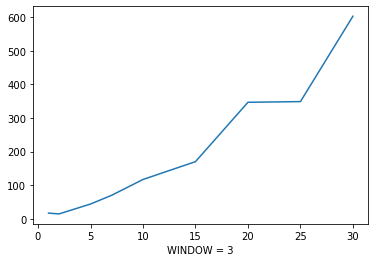

WINDOW_SIZE:  5
PREDICTION_HORIZON:  1
PREDICTION_HORIZON:  2
PREDICTION_HORIZON:  5
PREDICTION_HORIZON:  7
PREDICTION_HORIZON:  10
PREDICTION_HORIZON:  15
PREDICTION_HORIZON:  20
PREDICTION_HORIZON:  25
PREDICTION_HORIZON:  30
rmse_array: [10.996703519845596, 17.317895453616302, 72.78761151729987, 61.02060459539962, 155.4549275504271, 240.22194385007083, 345.2127623681954, 561.0491090251173, 232.36373606750794]


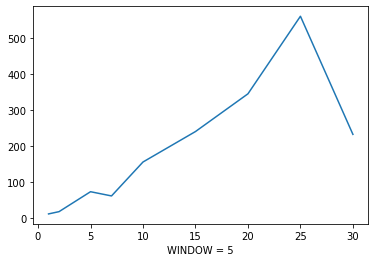

WINDOW_SIZE:  7
PREDICTION_HORIZON:  1
PREDICTION_HORIZON:  2
PREDICTION_HORIZON:  5
PREDICTION_HORIZON:  7
PREDICTION_HORIZON:  10
PREDICTION_HORIZON:  15
PREDICTION_HORIZON:  20
PREDICTION_HORIZON:  25
PREDICTION_HORIZON:  30
rmse_array: [25.992429989356424, 53.007806757020035, 70.49274356763794, 79.56338966147041, 182.64117154430278, 309.8191826774273, 310.52939637435816, 582.6489290275531, 292.5354137327995]


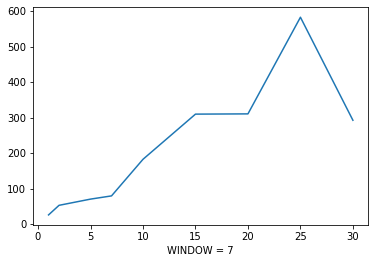

In [49]:
# Betti derivatives
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt

def exclude_days(train, test):

    row, column = train.shape
    train_days = np.asarray(train[:, -1]).reshape(-1, 1)
    x_train = train[:, 0:column - 1]
    test_days = np.asarray(test[:, -1]).reshape(-1, 1)
    x_test = test[:, 0:column - 1]

    return x_train, x_test, train_days, test_days

def merge_data(occurrence_data, daily_occurrence_normalized_matrix, aggregation_of_previous_days_allowed):
    if(aggregation_of_previous_days_allowed):
        if(occurrence_data.size==0):
            occurrence_data = daily_occurrence_normalized_matrix
        else:
            occurrence_data = np.add(occurrence_data, daily_occurrence_normalized_matrix)
    else:
        if(occurrence_data.size == 0):
            occurrence_data = daily_occurrence_normalized_matrix
        else:
            occurrence_data = np.concatenate((occurrence_data, daily_occurrence_normalized_matrix), axis=1)
   #print("merge_data shape: {} occurrence_data: {} ".format(occurrence_data.shape, occurrence_data))
    return occurrence_data
    
    
def get_normalized_matrix_from_file(day, year, totaltx):
    daily_occurrence_matrix_path_name = DAILY_OCCURRENCE_FILE_PATH + "occ" + str(year) + '{:03}'.format(day) + '.csv'
    daily_occurence_matrix = pd.read_csv(daily_occurrence_matrix_path_name, sep=",", header=None).values
   #print("daily_occurence_matrix.size: ", daily_occurence_matrix.size, daily_occurence_matrix.shape)
   #print("np.asarray(daily_occurence_matrix): ",np.asarray(daily_occurence_matrix))
   #print("np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size): ",np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size), np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size).shape, np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size).size)
   #print("totaltx: ",totaltx)
   #print("np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size)/totaltx: ",np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size)/totaltx)
    return np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size)/totaltx

def get_daily_occurrence_matrices(priced_bitcoin, current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
   #print("priced_bitcoin: ", priced_bitcoin, priced_bitcoin.shape)
   #print("current_row: ", current_row, current_row.shape)
    previous_price_data = np.array([], dtype=np.float32)
    occurrence_data = np.array([], dtype=np.float32)
    for index, row in priced_bitcoin.iterrows():
        if not ((row.values == current_row.values).all()):
            previous_price_data = np.append(previous_price_data, row['price'])
            previous_price_data = np.append(previous_price_data, row['totaltx'])
           #print("previous_price_data: ", previous_price_data,row['day'], row['year'], row['totaltx'])

    
   #print("occurrence_data: ", occurrence_data)
    if(is_price_of_previous_days_allowed):
       #print("previous_price_data: ", np.asarray(previous_price_data).reshape(1, -1), np.asarray(previous_price_data).reshape(1, -1).shape)
        occurrence_data = np.asarray(previous_price_data).reshape(1, -1)
        
    betti0_50 = read_betti(betti0_input_path, current_row['day'])
    occurrence_input = np.concatenate((occurrence_data, np.asarray(betti0_50).reshape(1,-1)), axis=1)
    betti0_50_diff1 = betti0_50.diff(1).dropna() 
    occurrence_input = np.concatenate((occurrence_input, np.asarray(betti0_50_diff1).reshape(1,-1)), axis=1)

    betti1_50 = read_betti(betti1_input_path, current_row['day'])
    occurrence_input = np.concatenate((occurrence_input, np.asarray(betti1_50).reshape(1,-1)), axis=1)
    betti1_50_diff1 = betti1_50.diff(1).dropna()
    #print("betti1_50_diff1: ", betti1_50_diff1, betti1_50_diff1.shape)
    occurrence_input = np.concatenate((occurrence_input, np.asarray(betti1_50_diff1).reshape(1,-1)), axis=1)

    occurrence_input = np.concatenate((occurrence_input, np.asarray(current_row['price']).reshape(1,1)), axis=1)
   #print("current_row['day']: ", current_row['day'], current_row['day'].shape)
   #print(" price occurrence_input: ", np.asarray(current_row['price']).reshape(1,1), (np.asarray(current_row['price']).reshape(1,1)).shape)
   #print("concatenate with price occurrence_input: ", occurrence_input, occurrence_input.shape)
    occurrence_input = np.concatenate((occurrence_input, np.asarray(current_row['day']).reshape(1,1)), axis=1)
   #print(" price occurrence_input: ", np.asarray(current_row['day']).reshape(1,1), (np.asarray(current_row['day']).reshape(1,1)).shape)

    #print("concatenate with day occurrence_input: ", occurrence_input, occurrence_input.shape)

    return occurrence_input


def print_results(predicted, test_target, original_log_return, predicted_log_return, cost, test_days, rmse):
    myFile = open('C:/Users/wang.yuhao/Documents/ChainNet/data/processed_data/rmse/' + str(YEAR) + ".csv", 'a')
    if(window_size == 1):
        myFile.write('IS_PRICE_OF_PREVIOUS_DAYS_ALLOWED:' + str(is_price_of_previous_days_allowed) + '\n')
        myFile.write('AGGREGATION_OF_PREVIOUS_DAYS_ALLOWED:' + str(aggregation_of_previous_days_allowed) + '\n')

        myFile.write('PREDICTION_HORIZON:' + str(prediction_horizon) + '\n')
    myFile.write('WINDOW_SIZE:' + str(window_size) + '\n')

    for p, t, o_l, p_l, t_d in zip(predicted, test_target, original_log_return, predicted_log_return, test_days):
        myFile.write(str(p) + "\t" + str(t) + "\t" + str(o_l) + "\t" + str(p_l) + "\t" + str(t_d) + '\n')
    myFile.write('TEST_COST:' + str(cost) + '\n')
    myFile.write('RMSE:' + str(rmse) + '\n')
    myFile.close()


def run_print_model(train_input, train_target, test_input, test_target, train_days, test_days):
    rf_regression = RandomForestRegressor(max_depth=2, random_state=0)
    rf_regression.fit(train_input, train_target.ravel() )
    predicted = rf_regression.predict(test_input)
    original_log_return = np.log(np.asarray(test_target).reshape(-1,)/test_input[:,-1])
    predicted_log_return = np.log(np.asarray(predicted).reshape(-1,)/test_input[:,-1])
    cost = sum(np.absolute(original_log_return-predicted_log_return))/original_log_return.size
    rmse = np.sqrt(metrics.mean_squared_error(test_target, predicted))
    print_results(predicted, test_target, original_log_return, predicted_log_return, cost, test_days, rmse)
    return rmse

def preprocess_data(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
    priced_bitcoin = pd.read_csv(PRICED_BITCOIN_FILE_PATH, sep=",")
    if(ALL_YEAR_INPUT_ALLOWED):
        pass
    else:
        priced_bitcoin = priced_bitcoin[priced_bitcoin['year']==YEAR].reset_index(drop=True)
    
    # get normalized occurence matrix in a flat format and merge with totaltx
    daily_occurrence_input = np.array([],dtype=np.float32)
    temp = np.array([], dtype=np.float32)
    for current_index, current_row in priced_bitcoin.iterrows():
        if(current_index<(window_size+prediction_horizon-1)):
            pass
        else:
            start_index = current_index - (window_size + prediction_horizon) + 1
            end_index = current_index - prediction_horizon
            temp = get_daily_occurrence_matrices(priced_bitcoin[start_index:end_index+1], current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)    
            #print("1st temp: ", temp, temp.shape)
        if(daily_occurrence_input.size == 0):
            daily_occurrence_input = temp
        else:
            #print("daily_occurrence_input: ", daily_occurrence_input, daily_occurrence_input.shape)
            #print("temp: ", temp, temp.shape)
            daily_occurrence_input = np.concatenate((daily_occurrence_input, temp), axis=0)
            #print("return daily_occurrence_input:", daily_occurrence_input, daily_occurrence_input.shape)
            
        #if current_index == 108:
            #print("daily_occurrence_input: ", daily_occurrence_input, daily_occurrence_input.shape)
    return daily_occurrence_input
        
betti0_input_path = "C:/Users/wang.yuhao/Documents/ChainNet/data/original_data/betti_0(100).csv"
betti1_input_path = "C:/Users/wang.yuhao/Documents/ChainNet/data/original_data/betti_1(100).csv"

def read_betti(file_path, day):
    day = day - 1
    betti = pd.read_csv(file_path, index_col=0)
    try:
        betti_50 = betti.iloc[day, 0:50]
    except:
        print("day:",  day)
            
    return betti_50
    
    
def initialize_setting(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
    data = preprocess_data(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)
    #train, test = train_test_split(data, test_size=TEST_SPLIT)
    #data = pd.DataFrame(data)
    train = data[0:100, :]
    test = data[101, :].reshape(1, -1)
    #print(" train, test shape",train.shape, test.shape)
    #print(" train, test",train, test)
    
    x_train, x_test, train_days, test_days = exclude_days(train, test)
    #print("x_train:", x_train)
    row, column = x_train.shape
    train_target = np.asarray(x_train[:, -1]).reshape(-1)
    train_input = x_train[:, 0:column - 1]
    #x_test = x_test.reshape(-1,1)
    test_target = x_test[: , -1]
    test_input = x_test[ : , 0:column - 1]
    return train_input, train_target, test_input, test_target, train_days, test_days

parameter_dict = {#0: dict({'is_price_of_previous_days_allowed':True, 'aggregation_of_previous_days_allowed':True})}
                  1: dict({'is_price_of_previous_days_allowed':True, 'aggregation_of_previous_days_allowed':False})}

for step in parameter_dict:
    gc.collect()
    evalParameter = parameter_dict.get(step)
    is_price_of_previous_days_allowed = evalParameter.get('is_price_of_previous_days_allowed')
    aggregation_of_previous_days_allowed = evalParameter.get('aggregation_of_previous_days_allowed')
    print("IS_PRICE_OF_PREVIOUS_DAYS_ALLOWED: ", is_price_of_previous_days_allowed)
    print("AGGREGATION_OF_PREVIOUS_DAYS_ALLOWED: ", aggregation_of_previous_days_allowed)
    window_size_array = [3, 5, 7]
    horizon_size_array = [1, 2, 5, 7, 10, 15, 20, 25, 30]
    for window_size in window_size_array:
        print('WINDOW_SIZE: ', window_size)
        rmse_array = []
        for prediction_horizon in horizon_size_array:
            print("PREDICTION_HORIZON: ", prediction_horizon)
            train_input, train_target, test_input, test_target, train_days, test_days = initialize_setting(window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)
            #print("train_input, train_target: ",train_input, train_target, train_input.shape, train_target.shape)
            #print("test_input, test_target",test_input, test_target, test_input.shape, test_target.shape)
            #print("train_days, test_days: ",train_days, test_days)
            rmse = run_print_model(train_input, train_target, test_input, test_target, train_days, test_days)
            rmse_array.append(rmse)
            
        print("rmse_array:", rmse_array)    
        plt.plot(horizon_size_array, rmse_array)
        plt.xlabel('WINDOW = {}'.format(window_size))
        plt.show()
        
        


In [96]:
# Gain
rf_base_data={
        'horizon':[1, 2, 5, 7, 10, 15, 20, 25, 30],
        'window_3': [12.832877531423264, 18.509245767866105, 66.66476270997691, 83.84262755140071, 92.06286536108928, 168.46719412949506, 334.25515671794733, 502.67172086715937, 463.46864208011766], 
      'window_5': [15.283981387542099, 27.527940692854827, 77.64689401293822, 79.69990740349726, 124.98468698259285, 233.70026291610407, 345.5498888892039, 539.6175619994922, 309.51835410333],
      'window_7': [25.269781370696137, 53.9848269882209, 66.23106860426788, 97.88427009297061, 164.65228849442065, 306.0274028956578, 419.15388232641794, 455.54630773279655, 472.29886564383855]}
rf_base_rmse = pd.DataFrame(rf_base_data, columns=['horizon','window_3', 'window_5', 'window_7'])
rf_betti_data={'window_3': [13.060495582872136, 17.58548407450644, 45.55190439335274, 86.86376369413301, 103.96516153140351, 162.97720124835723, 347.2111840960322, 365.0863552605301, 607.1192048408702],
               'window_5': [17.323702664027678, 24.11226149838012, 77.74046160817716, 82.13503767073075, 128.88469383817983, 238.3165165706173, 348.6321516330406, 514.4418509994518, 232.49094684228567],
               'window_7': [25.376655430498204, 55.32898247802723, 85.67709672002661, 79.9818570592688, 172.15773384869203, 306.8881306659846, 371.8673186155572, 571.8421154989296, 255.69975413625025]}
rf_betti_rmse =pd.DataFrame(rf_betti_data, columns=['window_3', 'window_5', 'window_7', index=horizon_size_array])

rf_betti_der_rmse = pd.DataFrame(data=[[16.665048358288686, 14.269135636688588, 43.70504466573084, 69.5523468437093, 116.73323339285753, 169.82334911449902, 346.4630104197274, 348.4969031736, 602.4986986545614],
                                       [10.996703519845596, 17.317895453616302, 72.78761151729987, 61.02060459539962, 155.4549275504271, 240.22194385007083, 345.2127623681954, 561.0491090251173, 232.36373606750794],
                                       [25.992429989356424, 53.007806757020035, 70.49274356763794, 79.56338966147041, 182.64117154430278, 309.8191826774273, 310.52939637435816, 582.6489290275531, 292.5354137327995]], index=['window_3', 'window_5', 'window_7'])

rf_fl_rmse = pd.DataFrame(data = [[16.17185272778056, 0.701860409351184, 46.6135843077318, 89.2310469053632, 73.94661318881776, 135.1676659318755, 287.5451063123728, 391.1122697369249, 289.5577809796023],
                           [15.052727175575455, 34.15092622505904, 100.18471825512756, 141.32083394787878, 147.00578128307484, 196.87769531961135, 285.9293616915104, 503.912912896182, 389.40637804593575],
                           [41.66292246169223, 64.94490696200592, 86.8825257048079, 95.56193059257271, 129.63002815605432, 269.4747584659003, 398.0102782013814, 506.56054220168994, 581.1080645069912]], index=['window_3', 'window_5', 'window_7'])

rf_betti_gain = 100 * (1 - rf_betti_rmse/rf_base_rmse)
rf_betti_gain.plot(x=rf_betti_gain.index,y ='window_3',  kind = 'bar')
plt.show()

SyntaxError: invalid syntax (<ipython-input-96-2255c3ea1ab2>, line 11)

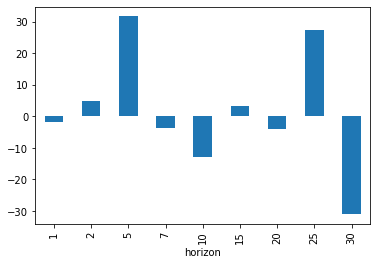

In [149]:
# Gain
rf_base_data={
        'horizon':[1, 2, 5, 7, 10, 15, 20, 25, 30],
        'window_3': [12.832877531423264, 18.509245767866105, 66.66476270997691, 83.84262755140071, 92.06286536108928, 168.46719412949506, 334.25515671794733, 502.67172086715937, 463.46864208011766], 
      'window_5': [15.283981387542099, 27.527940692854827, 77.64689401293822, 79.69990740349726, 124.98468698259285, 233.70026291610407, 345.5498888892039, 539.6175619994922, 309.51835410333],
      'window_7': [25.269781370696137, 53.9848269882209, 66.23106860426788, 97.88427009297061, 164.65228849442065, 306.0274028956578, 419.15388232641794, 455.54630773279655, 472.29886564383855]}
rf_base_rmse = pd.DataFrame(rf_base_data, columns=['horizon','window_3', 'window_5', 'window_7'])
rf_betti_data={
    'horizon':[1, 2, 5, 7, 10, 15, 20, 25, 30],
    'window_3': [13.060495582872136, 17.58548407450644, 45.55190439335274, 86.86376369413301, 103.96516153140351, 162.97720124835723, 347.2111840960322, 365.0863552605301, 607.1192048408702],
               'window_5': [17.323702664027678, 24.11226149838012, 77.74046160817716, 82.13503767073075, 128.88469383817983, 238.3165165706173, 348.6321516330406, 514.4418509994518, 232.49094684228567],
               'window_7': [25.376655430498204, 55.32898247802723, 85.67709672002661, 79.9818570592688, 172.15773384869203, 306.8881306659846, 371.8673186155572, 571.8421154989296, 255.69975413625025]}
rf_betti_rmse =pd.DataFrame(rf_betti_data, columns=['horizon','window_3', 'window_5', 'window_7'])

rf_betti_der_data={
    'horizon':[1, 2, 5, 7, 10, 15, 20, 25, 30],
     'window_3':[16.665048358288686, 14.269135636688588, 43.70504466573084, 69.5523468437093, 116.73323339285753, 169.82334911449902, 346.4630104197274, 348.4969031736, 602.4986986545614],
                                      'window_5': [10.996703519845596, 17.317895453616302, 72.78761151729987, 61.02060459539962, 155.4549275504271, 240.22194385007083, 345.2127623681954, 561.0491090251173, 232.36373606750794],
                                        'window_7':[25.992429989356424, 53.007806757020035, 70.49274356763794, 79.56338966147041, 182.64117154430278, 309.8191826774273, 310.52939637435816, 582.6489290275531, 292.5354137327995]}

rf_betti_der_rmse = pd.DataFrame(rf_betti_der_data, columns=['horizon','window_3', 'window_5', 'window_7'])

rf_fl_data = {
    'horizon':[1, 2, 5, 7, 10, 15, 20, 25, 30],
     'window_3': [16.17185272778056, 0.701860409351184, 46.6135843077318, 89.2310469053632, 73.94661318881776, 135.1676659318755, 287.5451063123728, 391.1122697369249, 289.5577809796023],
                           'window_5':[15.052727175575455, 34.15092622505904, 100.18471825512756, 141.32083394787878, 147.00578128307484, 196.87769531961135, 285.9293616915104, 503.912912896182, 389.40637804593575],
                           'window_7':[41.66292246169223, 64.94490696200592, 86.8825257048079, 95.56193059257271, 129.63002815605432, 269.4747584659003, 398.0102782013814, 506.56054220168994, 581.1080645069912]}
rf_fl_rmse = pd.DataFrame(rf_fl_data, columns=['horizon','window_3', 'window_5', 'window_7'])

rf_base_rmse.set_index('horizon', drop=True, inplace=True)
rf_betti_rmse.set_index('horizon', drop=True, inplace=True)
rf_betti_der_rmse.set_index('horizon', drop=True, inplace=True)
rf_fl_rmse.set_index('horizon', drop=True, inplace=True)

rf_betti_gain = 100 * (1 - rf_betti_rmse/rf_base_rmse)
rf_betti_der_gain = 100 * (1 - rf_betti_der_rmse/rf_base_rmse)
rf_fl_gain = 100 * (1 - rf_fl_rmse/rf_base_rmse)

rf_w3_gain = pd.concat([rf_betti_gain['window_3'], rf_betti_der_gain['window_3'],  rf_fl_gain['window_3']], axis=1)
rf_w3_gain
rf_betti_gain['window_3'].plot(x=rf_betti_gain, y=rf_betti_gain.index,kind = 'bar')


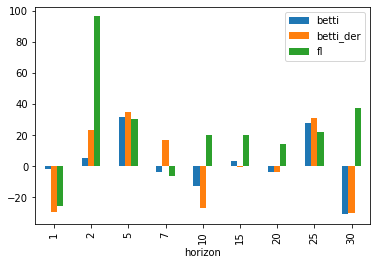

In [156]:

rf_w3_gain.columns = ['betti', 'betti_der', 'fl']
rf_w3_gain.plot(kind='bar')

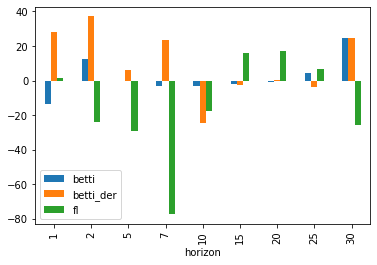

In [158]:
rf_w5_gain = pd.concat([rf_betti_gain['window_5'], rf_betti_der_gain['window_5'],  rf_fl_gain['window_5']], axis=1)
rf_w5_gain.columns = ['betti', 'betti_der', 'fl']
rf_w5_gain.plot(kind='bar')

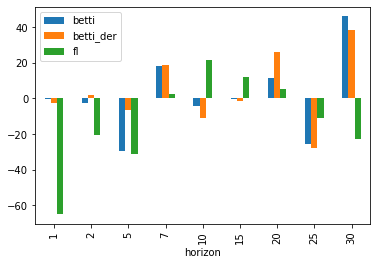

In [159]:
rf_w7_gain = pd.concat([rf_betti_gain['window_7'], rf_betti_der_gain['window_7'],  rf_fl_gain['window_7']], axis=1)
rf_w7_gain.columns = ['betti', 'betti_der', 'fl']
rf_w7_gain.plot(kind='bar')

In [157]:

rf_w3_gain


,betti,betti_der,fl
horizon,,,
1,-1.773710,-29.862132,-26.018913
2,4.990812,22.908065,96.208055
5,31.670192,34.440561,30.077627
7,-3.603341,17.044171,-6.426825
10,-12.928444,-26.797306,19.678132
15,3.258790,-0.804996,19.766180
20,-3.876089,-3.652256,13.974369
25,27.370819,30.671074,22.193302
30,-30.994667,-29.997727,37.523760
